<a href="https://colab.research.google.com/github/PariketPasari/tweerdata/blob/main/twitter_sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing and importing libraries

In [ ]:
pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#basic libraries and packages for Exploratory data analysis 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
import matplotlib.gridspec as gridspec
import matplotlib.patches as mpatches

In [ ]:
#mounting google drive to google collab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# core packages for text processing
import string
import re

In [ ]:
# libraries for text preprocessing 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perception_tagger')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Error loading averaged_perception_tagger: Package
[nltk_data]     'averaged_perception_tagger' not found in index


In [ ]:
# sklean pacakges for modeliing (SKLEARN PACKAGES)
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import LatentDirichletAllocation,NMF #not activly using in this code
from sklearn.metrics import confusion_matrix,classification_report, accuracy_score, precision_score,recall_score, f1_score
from sklearn.model_selection import train_test_split

In [ ]:
# utility 
import logging
import itertools
import os

In [ ]:
# core packages for genral use
import random, warnings, time, datetime

In [ ]:
# tensorflow for building model
import tensorflow as tf
from tensorflow.keras.layers import Embedding,Dense,LSTM,Bidirectional
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from transformers import BertTokenizer, TFBertModel

In [ ]:
# baisc option for genral use
stop = set(stopwords.words('english'))
plt.style.use('fivethirtyeight')
sns.set(font_scale=1.5)
pd.options.display.max_columns = 250
pd.options.display.max_rows = 250
warnings.filterwarnings('ignore')

Setting up basic variables and importing dataset and mapping labels

In [ ]:
# setting up dataset basic 
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
DATASET_ENCODING = 'ISO-8859-1'

# Settimg up sentiment variables
POSITIVE = "POSITIVE"
NEGATIVE = "NEGATIVE"
NEUTRAL  = "NEUTRAL"
SENTIMENT_THRESHOLDS = (0.4, 0.7)

# exporting keras model

KERAS_MODEL = "model.h5"


In [ ]:
# reading csv file and setting up encoding and column names
df = pd.read_csv('/content/drive/MyDrive/FINAL/data.csv', encoding = DATASET_ENCODING, names = DATASET_COLUMNS)

In [ ]:
#raw data 
df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [ ]:
# mapping taget label to string
# 0 to negative, 2 to neutral, 4 to positive

decode_map = {0: "NEGATIVE", 2: "NEUTRAL", 4: "POSITIVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df.target = df.target.apply(lambda x: decode_sentiment(x))

Data preprocessing (cleaning data)

In [ ]:
#cleaning text
# removing stop words, urls, html tags, puntuations from data using BERT
# creating functions for each process

In [ ]:
#stopwords removal fucntions
def remove_stopwords(text):
    tokens = []
    for token in text.split():
        if token not in stop:
            tokens.append(token)
    return " ".join(tokens)

In [ ]:
# url removal function
def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.S+')
    return url.sub(r'', text)

In [ ]:
# html tags removal function

def remove_html(text):
    html = re.compile(r'<.*?>|&([a-z0-9]+|#[0-9]{1.6}|#x[0-9a-f]{1,6});')
    return re.sub(html,'',text)

In [ ]:
# puntuations removal function
def remove_punct(text):
    table = str.maketrans('', '', string.punctuation)
    return text.translate(table)

In [ ]:
# applying helper function to apply all the above created fucntions for text cleaning

df['text_clean'] = df['text'].apply(lambda x: remove_stopwords(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_URL(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_html(x))
df['text_clean'] = df['text_clean'].apply(lambda x: remove_punct(x))

In [ ]:
 #processed data
 df.head()

,target,ids,date,flag,user,text,text_clean
0,NEGATIVE,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot Awww thats bummer You shoulda got...
1,NEGATIVE,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,upset cant update Facebook texting it might cr...
2,NEGATIVE,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,Kenichan I dived many times ball Managed save ...
3,NEGATIVE,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,NEGATIVE,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",nationwideclass no behaving all im mad here I ...


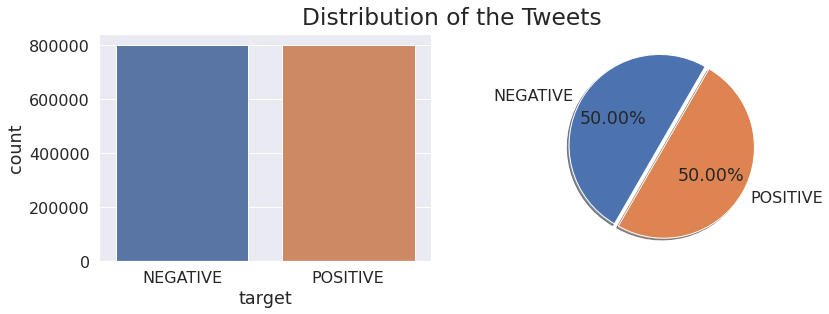

In [ ]:
# Displaying target distribution.

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12, 4), dpi=70)
sns.countplot(df['target'], ax=axes[0])
axes[1].pie(df['target'].value_counts(),
            labels=[NEGATIVE, POSITIVE],
            autopct='%1.2f%%',
            shadow=True,
            explode=(0.05, 0),
            startangle=60)
fig.suptitle('Distribution of the Tweets', fontsize=24)
plt.show()

Data Visualizations

In [ ]:
# Creating a new feature for the visualization.

df['Character Count'] = df['text_clean'].apply(lambda x: len(str(x)))


def plot_dist3(df_x, feature, title):
    # Creating a customized chart. and giving in figsize and everything.
    fig = plt.figure(constrained_layout=True, figsize=(16, 6))
    # Creating a grid of 3 cols and 3 rows.
    grid = gridspec.GridSpec(ncols=3, nrows=3, figure=fig)

    # Customizing the histogram grid.
    ax1 = fig.add_subplot(grid[0, :2])
    # Set the title.
    ax1.set_title('Histogram')
    # plot the histogram.
    sns.distplot(df_x.loc[:, feature],
                 hist=True,
                 kde=True,
                 ax=ax1,
                 color='darkcyan')
    ax1.set(ylabel='Frequency')
    ax1.xaxis.set_major_locator(MaxNLocator(nbins=20))

    # Customizing the ecdf_plot.
    ax2 = fig.add_subplot(grid[1, :2])
    # Set the title.
    ax2.set_title('Empirical Cumulative Distribution Function')
    # Plotting the ecdf_Plot.
    sns.distplot(df.loc[:, feature],
                 ax=ax2,
                 kde_kws={'cumulative': True},
                 hist_kws={'cumulative': True},
                 color='skyblue')
    ax2.xaxis.set_major_locator(MaxNLocator(nbins=20))
    ax2.set(ylabel='Cumulative Probability')

    # Customizing the Box Plot.
    ax3 = fig.add_subplot(grid[:, 2])
    # Set title.
    ax3.set_title('Box Plot')
    # Plotting the box plot.
    sns.boxplot(x=feature, data=df, orient='v', ax=ax3, color='lightcoral')
    ax3.yaxis.set_major_locator(MaxNLocator(nbins=25))

    plt.suptitle(f'{title}', fontsize=24)

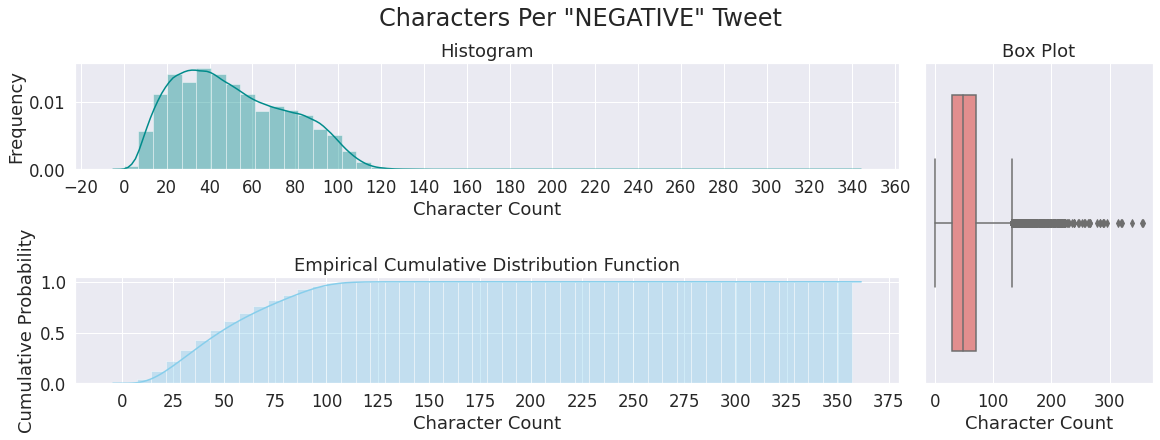

In [ ]:
#plot for negative tweets
plot_dist3(df[df['target'] == 'NEGATIVE'], 'Character Count',
           'Characters Per "NEGATIVE" Tweet')

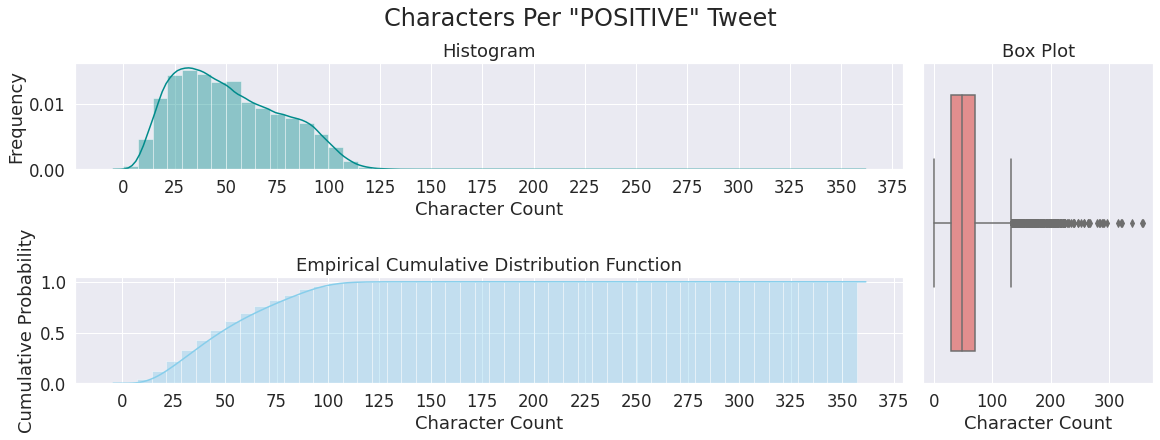

In [ ]:
#plot for positive tweets
plot_dist3(df[df['target'] == "POSITIVE"], 'Character Count','Characters Per "POSITIVE" Tweet')

Exception Handeling

In [ ]:
#setting up environment
os.environ["WANDB_API_KEY"] = "0"

In [ ]:
#allocating tpu and handling exception in it
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    strategy = tf.distribute.get_strategy()
    print('number of replicas: ',strategy.num_replicas_in_sync)


label encoding, setting tokenizer, data splitting

In [ ]:
#setting up hyperparameters
max_length = 140
batch_size = 512

In [ ]:
# BERT tokenizer
model_name = "bert-base-uncased"
tokenizer = BertTokenizer.from_pretrained(model_name)

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
# splitting the data
train_df,test = train_test_split(df,test_size = 0.02, random_state = 42)
x_train, dev = train_test_split(train_df,test_size = 0.01, random_state = 42)

In [ ]:
print(x_train.shape)
print(test.shape)
print(dev.shape)

(1552320, 8)
(32000, 8)
(15680, 8)


In [ ]:
#decreasing the data from 1.6 million to 0.5 million to reduce porocessing time
train = x_train[:600000]

In [ ]:
# creating a label 

labels = train.target.unique().tolist()
labels.append(NEUTRAL)
labels

['POSITIVE', 'NEGATIVE', 'NEUTRAL']

In [ ]:
#encoding labels
encoder = LabelEncoder()
encoder.fit(train.target.tolist())

y_train = encoder.transform(train.target.tolist())
y_test = encoder.transform(test.target.tolist())
y_dev = encoder.transform(dev.target.tolist())

y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)
y_dev = y_dev.reshape(-1,1)

print("y train",y_train.shape)
print("y test",y_test.shape)

y train (600000, 1)
y test (32000, 1)


In [ ]:
def bert_encode(data):
    tokens = tokenizer.batch_encode_plus(data, max_length = max_length, padding = 'max_length', truncation=True)
    return tf.constant(tokens['input_ids'])

In [ ]:
train_encoded = bert_encode(train.text_clean)
dev_encoded = bert_encode(dev.text_clean)

train_dataset = (
    tf.data.Dataset
    .from_tensor_slices((train_encoded,y_train))
    .shuffle(128)
    .batch(batch_size)
)

dev_dataset = (
    tf.data.Dataset
    .from_tensor_slices((dev_encoded,y_dev))
    .shuffle(128)
    .batch(batch_size)
)

Model building

In [ ]:
# proposed model

def bert_model():
    bert_encoder = TFBertModel.from_pretrained(model_name)
    input_word_ids = tf.keras.Input(shape = (max_length,), dtype = tf.int32, name = "input_ids")

    last_hidden_states = bert_encoder(input_word_ids)[0]

    x = tf.keras.layers.SpatialDropout1D(0.2)(last_hidden_states)
    x = tf.keras.layers.Conv1D(32,3, activation = 'relu')(x)
    x = tf.keras.layers.Bidirectional(LSTM(100, dropout = 0.2, recurrent_dropout = 0.2))(x)

    outputs = tf.keras.layers.Dense(1, activation = 'sigmoid')(x)
    model = tf.keras.Model(input_word_ids,outputs)
    
    return model


In [ ]:
with strategy.scope():
    model = bert_model()
    adam_optimizer = tf.keras.optimizers.Adam(learning_rate = 1e-4)
    model.compile(loss = 'binary_crossentropy',optimizer = adam_optimizer, metrics = ['accuracy'])
    model.summary()


Downloading:   0%|          | 0.00/536M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_ids (InputLayer)      [(None, 140)]             0         
                                                                 
 tf_bert_model (TFBertModel)  TFBaseModelOutputWithPoo  109482240
                             lingAndCrossAttentions(l            
                             ast_hidden_state=(None,             
                             140, 768),                          
                              pooler_output=(None, 76            
                             8),                                 
                              past_key_values=None, h            
                             idden_states=None, atten            
                             tions=None, cross_attent            
                             ions=None)                          
                                                             

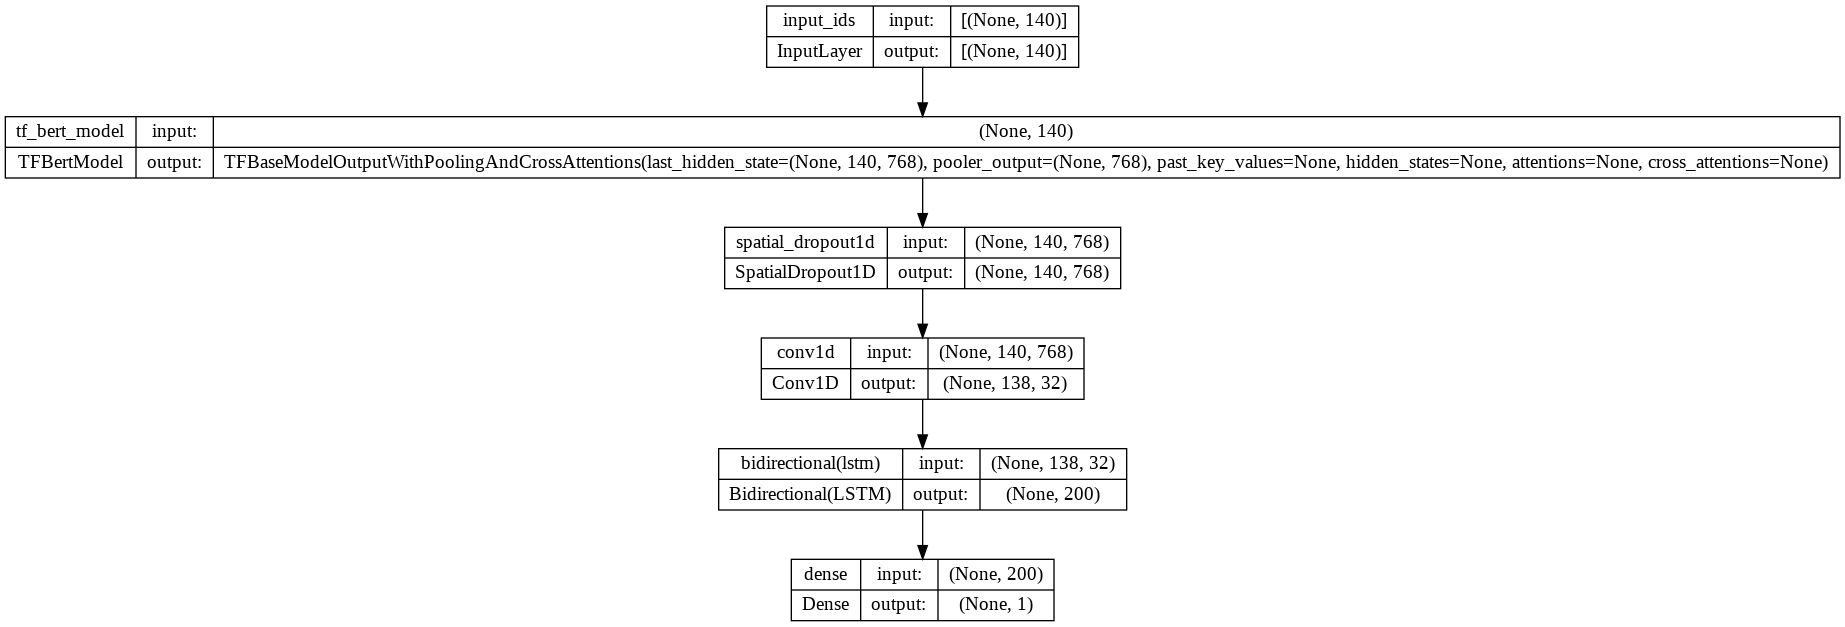

In [ ]:
#plotting our model
tf.keras.utils.plot_model(model, show_shapes = True)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ReduceLROnPlateau(monitor = 'val_loss',patience = 5, cooldown = 0),
             EarlyStopping(monitor = 'val_acc',min_delta = 1e-5,patience = 5)]

Training model

In [ ]:
#trainig the model
history = model.fit(
    train_dataset,
    batch_size = batch_size,
    epochs = 4,
    validation_data = dev_dataset,
    verbose = 1,
    callbacks = callbacks )

Epoch 1/4


1172/1172 [==============================] - ETA: 0s - loss: 0.4475 - accuracy: 0.7887

1172/1172 [==============================] - 793s 595ms/step - loss: 0.4475 - accuracy: 0.7887 - val_loss: 0.4005 - val_accuracy: 0.8162 - lr: 1.0000e-04
Epoch 2/4
1172/1172 [==============================] - ETA: 0s - loss: 0.3748 - accuracy: 0.8327

1172/1172 [==============================] - 627s 535ms/step - loss: 0.3748 - accuracy: 0.8327 - val_loss: 0.4230 - val_accuracy: 0.8101 - lr: 1.0000e-04
Epoch 3/4
1172/1172 [==============================] - ETA: 0s - loss: 0.3086 - accuracy: 0.8686

1172/1172 [==============================] - 629s 536ms/step - loss: 0.3086 - accuracy: 0.8686 - val_loss: 0.4800 - val_accuracy: 0.8029 - lr: 1.0000e-04
Epoch 4/4
1172/1172 [==============================] - ETA: 0s - loss: 0.2462 - accuracy: 0.9000

1172/1172 [==============================] - 627s 535ms/step - loss: 0.2462 - accuracy: 0.9000 - val_loss: 0.5428 - val_accuracy: 0.7993 - lr: 1.0000e-04


In [ ]:
#saving the model
model.save_weights(f'sentiment_weights_v1.h5')

In [ ]:
# creating a functon to plot graph of val_loss and val_accuracy

def plot_graphs(history,string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string,'val_'+string])
    plt.show()

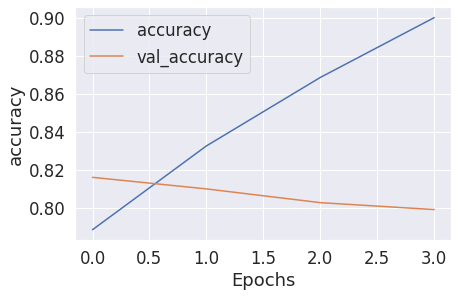

In [ ]:
#graph of accuracy

plot_graphs(history,"accuracy")

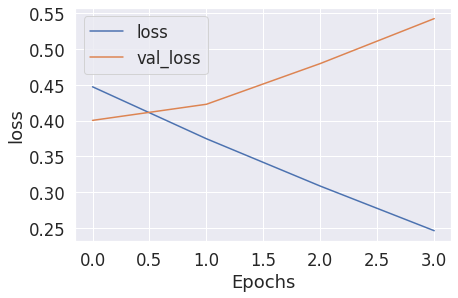

In [ ]:
#graph of loss

plot_graphs(history,"loss")

Model testing

In [ ]:
# trying manual prediction before using test data

#setting up label conditions for output
def decode_sentiment(score, include_neutral = False):
    if include_neutral:
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score>= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE
        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
# creating a function to take user input and show predictions on it

def predict(text,include_neutral = False):
    start_at = time.time()
    x_encoded = bert_encode([text]) # tokenizing text
    score = model.predict([x_encoded])[0] #predictions
    label = decode_sentiment(score, include_neutral = include_neutral) #decoding sentiment
    return {"Label": label, "Score": float(score)}

In [ ]:
# testing the predict function

predict("I hate economy")

1/1 [==============================] - 12s 12s/step


{'Label': 'NEGATIVE', 'Score': 0.002718508243560791}

In [ ]:
predict("I LOVE PYTHON")

1/1 [==============================] - 1s 534ms/step


{'Label': 'POSITIVE', 'Score': 0.9946615099906921}

In [ ]:
predict("Excited to present a tutorial on 'Modular and Parameter-Efficient Fine-Tuning for NLP Models' \
        at #EMNLP2022 with @PfeiffJo & @licwu.")

1/1 [==============================] - 1s 525ms/step


{'Label': 'POSITIVE', 'Score': 0.9972739815711975}

In [ ]:
predict("I forgot how cringy all the Slavic names sound read it English \
YOU'RE PRONOUNCING IT ALL WRONG MY EARS ARE HURTING AND I DON'T EVEN HAVE HEARING AIDS IN")

1/1 [==============================] - 1s 549ms/step


{'Label': 'NEGATIVE', 'Score': 0.0047151148319244385}

In [ ]:
predict("For the third time in four years, the Warriors are champions once again.\
This time, they wasted no time in the NBA Finals, dispatching LeBron James and the Cavs in four straight games.\
Here’s how they sealed the championship in Game 4. https://twitter.com/i/moments/1005197277663641600")

1/1 [==============================] - 0s 497ms/step


{'Label': 'POSITIVE', 'Score': 0.9350607991218567}

In [ ]:
# testing results

test_encoded = bert_encode(test.text_clean)

test_dataset = tf.data.Dataset.from_tensor_slices(test_encoded).batch(batch_size)

y_pred = []
predicted_tweets = model.predict(test_dataset, batch_size = batch_size)
predicted_tweets_binary = tf.cast(tf.round(predicted_tweets),tf.int32).numpy().flatten()

63/63 [==============================] - 27s 355ms/step


In [ ]:
scores = model.evaluate(test_encoded, y_test, batch_size = batch_size)
print()
print("Accuracy: ",scores[1])
print("Loss: ",scores[0])

63/63 [==============================] - 16s 253ms/step - loss: 0.5465 - accuracy: 0.8015

Accuracy:  0.8015313148498535
Loss:  0.5464802980422974


model enhancement

In [ ]:
# to decrese bad predictions in our old predictions

In [ ]:
def decode_sentiment(score, include_neutral=False):
    if include_neutral:        
        label = NEUTRAL
        if score <= SENTIMENT_THRESHOLDS[0]:
            label = NEGATIVE
        elif score >= SENTIMENT_THRESHOLDS[1]:
            label = POSITIVE

        return label
    else:
        return NEGATIVE if score < 0.5 else POSITIVE

In [ ]:
def improved_prediction(text, include_neutral=False):
    # Applying helper functions
    text = remove_stopwords(text)
    text = remove_URL(text)
    text = remove_html(text)
    text = remove_punct(text)
    # Tokenize text
    x_encoded = bert_encode([text])
    # Predict
    score = model.predict([x_encoded])[0]
    # Decode sentiment
    label = decode_sentiment(score, include_neutral=include_neutral)

    return {"label": label, "score": float(score)}

In [ ]:
improved_prediction("life is really strange isn't it? just the combination of laugh and cry",True)

1/1 [==============================] - 1s 709ms/step


{'label': 'NEUTRAL', 'score': 0.4357554018497467}

In [ ]:
# predicting a paragraph

improved_prediction("Had a song stuck in my head. Thirty seconds later I'm listening to it, thanks to the internet,\
        and Apple/YouTube Music. In the bad old days I'd browse record stores for hours in the hope that the title might jog my memory.\
        It really is a wonderful time to be alive!")

1/1 [==============================] - 1s 760ms/step


{'label': 'POSITIVE', 'score': 0.9679139256477356}

In [ ]:
y_pred = [decode_sentiment(predicted_tweets) for predicted_tweets in scores]
y_pred

['POSITIVE', 'POSITIVE']

In [ ]:
def plot_confusion_matrix(cm, classes,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=16)
    plt.yticks(tick_marks, classes, fontsize=16)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)

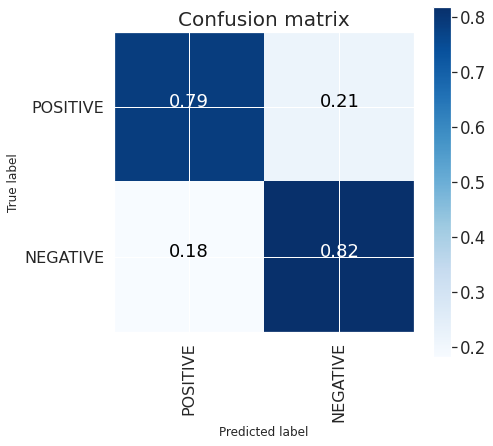

In [ ]:
cnf_matrix = confusion_matrix(y_test, predicted_tweets_binary)
plt.figure(figsize=(6,6))
plot_confusion_matrix(cnf_matrix, classes=train.target.unique(), title="Confusion matrix")
plt.show()

In [ ]:
#comprehensive stastical report
print('Precision: %.4f' % precision_score(y_test, predicted_tweets_binary))
print('Recall: %.4f' % recall_score(y_test, predicted_tweets_binary))
print('Accuracy: %.4f' % accuracy_score(y_test, predicted_tweets_binary))
print('F1 Score: %.4f' % f1_score(y_test, predicted_tweets_binary))
print(classification_report(y_test, predicted_tweets_binary))

Precision: 0.7913
Recall: 0.8181
Accuracy: 0.8015
F1 Score: 0.8045
              precision    recall  f1-score   support

           0       0.81      0.79      0.80     16031
           1       0.79      0.82      0.80     15969

    accuracy                           0.80     32000
   macro avg       0.80      0.80      0.80     32000
weighted avg       0.80      0.80      0.80     32000



Error analysis and handling it

In [ ]:
# Error Analysis

decode_map = {0: "NEGATIVE", 1: "POSITVE"}
def decode_sentiment(label):
    return decode_map[int(label)]

In [ ]:
df1 = pd.DataFrame(test.text, columns=["text"])
df1['ids'] = test.ids
df1["actual"] = test.target
df1["predicted"] = predicted_tweets_binary
df1.predicted = df1.predicted.apply(lambda x: decode_sentiment(x))
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)
incorrect = df1[df1["actual"] != df1["predicted"]]
incorrect[10:20]

,text,ids,actual,predicted
1399246,Whaddup Whaddup Whaddup Whaddup Whaddup I Got white girl swag from MY HEAD TO MY shOES Whaddup @yungla,2054208245,POSITIVE,POSITVE
1042030,"@GogDog I'd be willing to pay $40-50 (thus covering the cost of the set) for one of them, but if you've got a counter offer I'll listen.",1957149371,POSITIVE,POSITVE
1589403,Working on photos from Hillsong's 1 year celebration!!! stay tuned www.hillsong.co.za,2191233426,POSITIVE,POSITVE
1084782,@edadkins ha ha I want to see pictures from when you were a minister!!! *boobie flahses*!!!!,1969042558,POSITIVE,POSITVE
833693,im turning 18 one week from now but i don't feel excited i really don't know why i've seen my friends they got excited but on my part,1557804294,POSITIVE,POSITVE
977527,No woooooork tomorrrow&amp;tuesday,1833745318,POSITIVE,NEGATIVE
215315,Too full of fizz but not enough cider,1975439689,NEGATIVE,POSITVE
1541646,How to Get Your Ex Back (worked for me http://bit.ly/ec8qJ,2180848798,POSITIVE,POSITVE
1569655,Hahaha blakk is reckkkin it. :p throwwwwwed.,2188435142,POSITIVE,POSITVE
1178920,Cubs game today! My first ever,1981659749,POSITIVE,POSITVE


In [ ]:
correct = df1[df1['actual'] == df1['predicted']]
correct.head(5)

,text,ids,actual,predicted
541200,@chrishasboobs AHHH I HOPE YOUR OK!!!,2200003196,NEGATIVE,NEGATIVE
285055,School email won't open and I have geography stuff on there to revise! *Stupid School* :'(,1993474027,NEGATIVE,NEGATIVE
705995,upper airways problem,2256550904,NEGATIVE,NEGATIVE
379611,Going to miss Pastor's sermon on Faith...,2052380495,NEGATIVE,NEGATIVE
667030,@piginthepoke oh why are you feeling like that?,2245479748,NEGATIVE,NEGATIVE
